In [3]:
import numpy as np
from features import get_features, get_hog_features
from tqdm.auto import tqdm 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import cv2

# 1. Prepare Dataset

In [4]:
FOLDER = "Car-Bike-Dataset"
data, label = get_features(root_dir=FOLDER)
data_bike, label_bike = data[:2000], label[:2000]
data_car, label_car = data[2000:], label[2000:]

100%|██████████| 2000/2000 [00:53<00:00, 37.53it/s]


In [5]:
# Split data each class into train and val
train_bike, val_bike, train_label_bike, val_label_bike = train_test_split(data_bike, label_bike, 
                                                                          test_size=0.2, random_state=42, shuffle=True) 
train_car, val_car, train_label_car, val_label_car = train_test_split(data_car, label_car, 
                                                                      test_size=0.2, random_state=42, shuffle=True)

In [6]:
# Combine train and val of bike and car 
np.random.seed(42)
train_data = np.concatenate((train_bike, train_car))
train_label = np.concatenate((train_label_bike, train_label_car))
val_data = np.concatenate((val_bike, val_car))
val_label = np.concatenate((val_label_bike, val_label_car))

# Convert label into 2D
train_label = train_label.reshape(-1, 1)
val_label = val_label.reshape(-1, 1)

# Combine data and label 
train = np.hstack((train_data, train_label))
np.random.shuffle(train)
val = np.hstack((val_data, val_label))
np.random.shuffle(val)

In [7]:
# Split the shuffled array back into separate arrays for data and labels:
train_dataloader, label_dataloader = train[:, :-1], train[:, -1]
val_dataloader, val_label_dataloader = val[:, :-1], val[:, -1]

In [7]:
print(f"The number of datasets for training: {len(train_dataloader)}")
print(f"The number of datasets for validation: {len(val_dataloader)}")

The number of datasets for training: 3200
The number of datasets for validation: 800


In [8]:
print(f"Shape of train: {train_dataloader.shape}")
print(f"Shape of validation: {val_dataloader.shape}")

Shape of train: (3200, 26244)
Shape of validation: (800, 26244)


# 2. Model with Randomized Search

In [ ]:
params = {'n_estimators': [100, 150, 160, 180],
          'max_depth': [3, 5, 7, 10],
          'min_samples_split': [2, 6, 8, 10],
          'min_samples_leaf': [3, 6, 8, 10],
          'max_leaf_nodes': [2, 5, 10]}
random_forest = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(random_forest, param_distributions=params, 
                                   n_iter=10, scoring='accuracy', random_state=42)

In [12]:
random_search.fit(train_dataloader, label_dataloader)
cv_results = random_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Accuracy: {mean_score:.4f}, Params: {params}")

Accuracy: 0.8712, Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_leaf_nodes': 5, 'max_depth': 10}
Accuracy: 0.8834, Params: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 10, 'max_depth': 5}
Accuracy: 0.8228, Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 2, 'max_depth': 10}
Accuracy: 0.8747, Params: {'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 5, 'max_depth': 10}
Accuracy: 0.8744, Params: {'n_estimators': 150, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_leaf_nodes': 5, 'max_depth': 7}
Accuracy: 0.8228, Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_leaf_nodes': 2, 'max_depth': 5}
Accuracy: 0.8709, Params: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_leaf_nodes': 5, 'max_depth': 3}
Accuracy: 0.8834, Params: {'n_estimators': 100, 'min_samples_split':

In [14]:
best_model = random_search.best_estimator_
print(f"Best Accuracy: {random_search.best_score_}, Best Param: {random_search.best_params_}")

Best Accuracy: 0.8834375, Best Param: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 10, 'max_depth': 5}


In [27]:
# Save model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "random_forest.joblib"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
joblib.dump(best_model, MODEL_SAVE_PATH)

['models\\random_forest.joblib']

In [8]:
# Load model
model_random_forest = joblib.load('models\\random_forest.joblib')

# 3. Testing

In [12]:
y_pred = model_random_forest.predict(val_dataloader)
acc = accuracy_score(y_true=val_label_dataloader, y_pred=y_pred)
print(f"Accuracy of model Random Forest: {acc:.4f}")
print(f"Classification report: \n {classification_report(y_true=val_label_dataloader, y_pred=y_pred)}")

Accuracy of model Random Forest: 0.8912
Classification report: 
               precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       400
         1.0       0.88      0.91      0.89       400

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



<Figure size 1500x700 with 0 Axes>

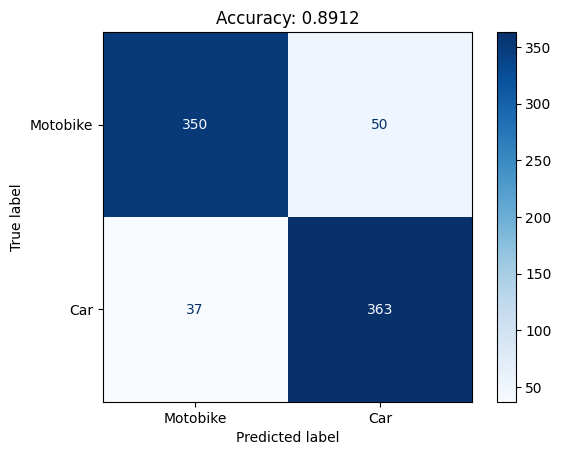

In [34]:
class_name = ["Motobike", "Car"]
cm = confusion_matrix(y_true=val_label_dataloader, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
plt.figure(figsize=(15, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Accuracy: {acc:.4f}")
plt.savefig("Confusion_matrix.png")
plt.show()

In [25]:
import random, os
from pathlib import Path
random.seed(42)
vehicles = list(sorted(os.listdir(FOLDER)))
vehicle_path = [os.path.join(FOLDER, vehicle) for vehicle in vehicles]
list_bike = [Path(os.path.join(vehicle_path[0]), image) for image in list(sorted(os.listdir(vehicle_path[0])))]
list_car = [Path(os.path.join(vehicle_path[1]), image) for image in list(sorted(os.listdir(vehicle_path[1])))]
random_images = random.sample(list_car, k=6) + random.sample(list_bike, k=6)

class_name = {0: "MotorBike", 1: "Car"}
class_to_idx = {"Bike": 0, "Car": 1} # Bike là Motorbike
test_samples = []
test_hog_features = []
test_labels = []
for image in random_images:
    img = cv2.imread(image)
    resized_img = cv2.resize(img, (224, 224))
    img_gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    hog_feature = get_hog_features(img_gray)
    test_samples.append(resized_img)
    test_hog_features.append(hog_feature)
    test_labels.append(class_to_idx[image.parent.name])
pred_classes = model_random_forest.predict(test_hog_features)

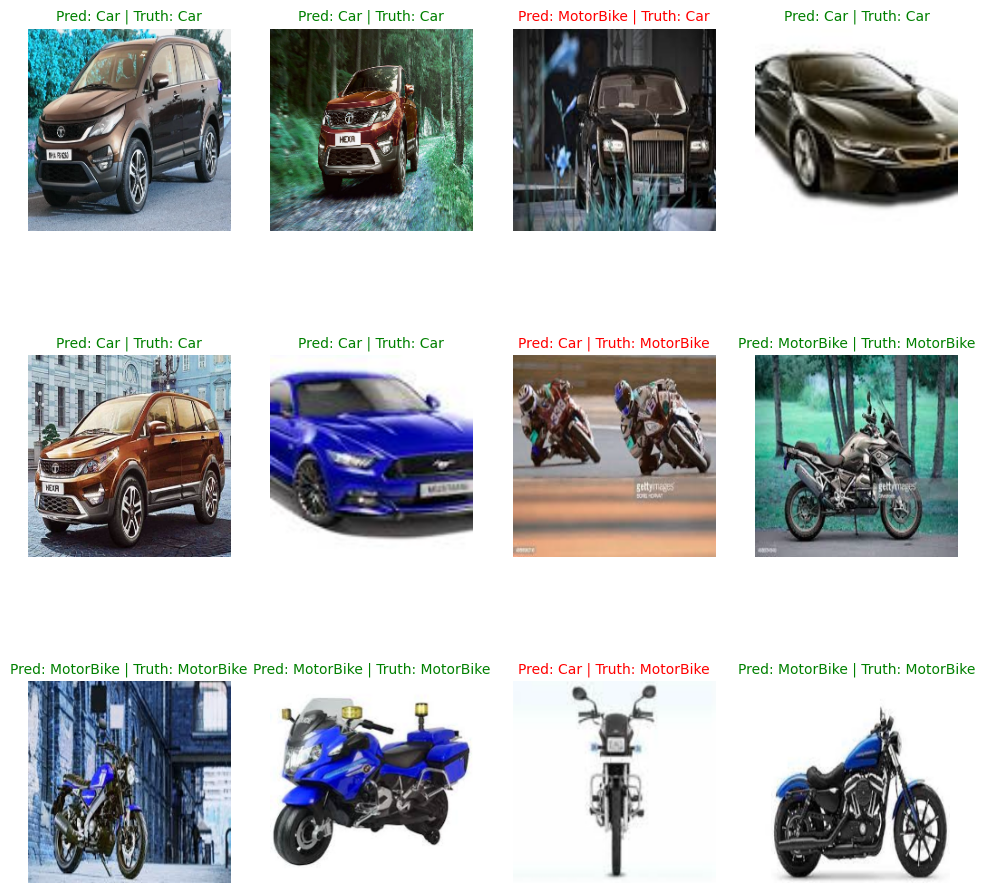

In [30]:
plt.figure(figsize=(12, 12))
nrows = 3
ncols = 4
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample)

    pred_label = class_name[pred_classes[i]]

    truth_label = class_name[test_labels[i]] 

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False)

plt.savefig("test.png")
plt.show()

# 5. Testing with a image

Prob of Motobike: 78.31%
Prob of Car: 21.69%


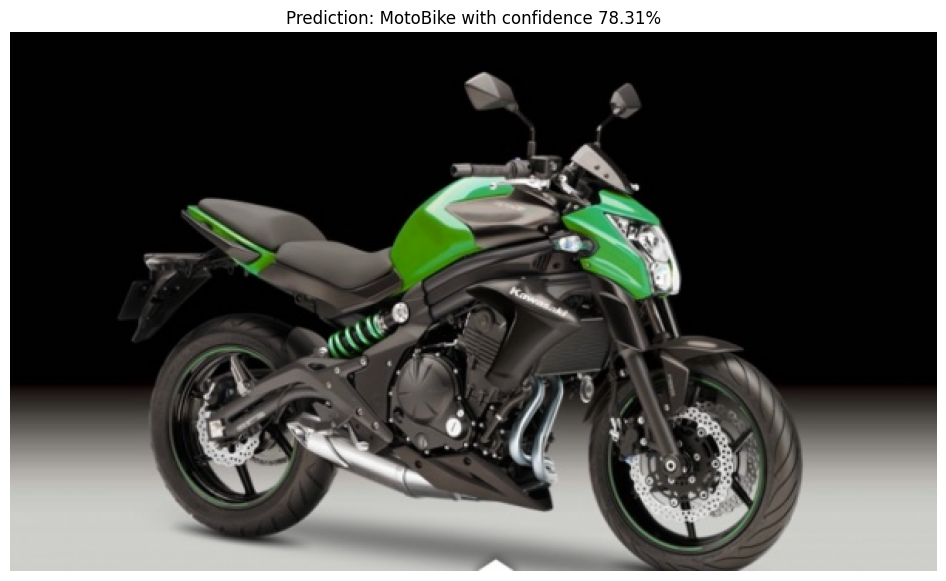

In [57]:
image = "xe_may.jpg"
img = cv2.imread(image)
resized_img = cv2.resize(img, (224, 224))
gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
hog_feature = get_hog_features(img=gray)
prob = model_random_forest.predict_proba(hog_feature.reshape(1, -1))[0]
print(f"Prob of Motobike: {prob[0]*100:.2f}%")
print(f"Prob of Car: {prob[1]*100:.2f}%")
plt.figure(figsize=(15, 7))
plt.imshow(img)
plt.title(f"Prediction: {class_name[prob.argmax()]} with confidence {prob[0]*100:.2f}%")
plt.axis("off")
plt.show()

In [9]:
params = {'n_estimators': [100, 150, 160, 180],
          'max_depth': [3, 5, 7, 10],
          'min_samples_split': [2, 6, 8, 10],
          'min_samples_leaf': [3, 6, 8, 10],
          'max_leaf_nodes': [2, 5, 10]}
random_forest = RandomForestClassifier()
random_search = RandomizedSearchCV(random_forest, param_distributions=params, 
                                   n_iter=20, scoring='accuracy', random_state=42)

In [10]:
random_search.fit(train_dataloader, label_dataloader)
cv_results = random_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Accuracy: {mean_score:.4f}, Params: {params}")

Accuracy: 0.8706, Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_leaf_nodes': 5, 'max_depth': 10}
Accuracy: 0.8775, Params: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 10, 'max_depth': 5}
Accuracy: 0.8228, Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 2, 'max_depth': 10}
Accuracy: 0.8669, Params: {'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 5, 'max_depth': 10}
Accuracy: 0.8706, Params: {'n_estimators': 150, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_leaf_nodes': 5, 'max_depth': 7}
Accuracy: 0.8247, Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_leaf_nodes': 2, 'max_depth': 5}
Accuracy: 0.8700, Params: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_leaf_nodes': 5, 'max_depth': 3}
Accuracy: 0.8737, Params: {'n_estimators': 100, 'min_samples_split':